# Deseason timeseries and predict with ARIMA again

In [29]:
import pandas as pd

import numpy as np
import pmdarima as pm
from statsmodels.tsa import seasonal
import matplotlib
# matplotlib.use('nbagg')
import matplotlib.pylab as plt
import joblib

import seaborn as sns
# from matplotlib import rcParams  

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
sns.set()


In [2]:
# Load clean
raw_pd = pd.read_csv('../data/interim/trips_per_hour_dropped_na_and_all_outliers_under_001_and_over_999.csv')
raw_pd.request_date = pd.to_datetime(raw_pd.request_date)
ts = raw_pd.set_index(raw_pd.request_date)['trip_counts']
ts_df = pd.DataFrame(ts)

## Stationarity for frequency components

Lets see how stationary the timeseries is once again, and later see if we can decompose the trend from the seasonalities.

In [3]:
from src.models.stats_tests import test_stationarity

In [4]:
# Initial test on data, KPSS test is not perfect, suggesting there is a non-stationary component in the series
sttest_0 = test_stationarity(ts, plot=False, method="KPSS")

Results of KPSS Test:
Test Statistic            0.361921
p-value                   0.010000
#Lags Used               28.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


In [5]:
# Fortunately the ADF test, suggests with higher certainty that any non-stationary component can be transformed.
sttest_1 = test_stationarity(ts, plot=False, method="ADF")

Results of ADF Test:
Test Statistic          -4.525687
p-value                  0.000177
#Lags Used              28.000000
Critical Value (1%)     -3.432626
Critical Value (5%)     -2.862545
Critical Value (10%)    -2.567305
dtype: float64


# Decomposing

Let's decompose the timeseries , by removing the hour-of-day component first and then the day-of-week.

Using a mutiplicative model and a frequency of 24 first, to decompose hour-of-day seasonality and then decompose the resulting trend even further, with frequency 7, to remove the day-of-week seasonality.

## Decompose the 24h cycle

In [6]:
from src.visualization.visualize import plot_decomposition

In [7]:
decomp = seasonal.seasonal_decompose(ts, model='multiplicative', freq=24)

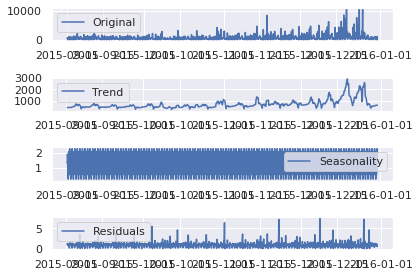

In [8]:
plot_decomposition(plt, ts, decomp)
plt.show()

### Lets have a closer look
It is clear that the original (first graph) series has decomposed to a simple timeseries (second graph) of the trend and a seasonality component (third graph). Also, the residual (fourth graph), when looked at more closely below seems to still contain some pattern. Therefore a second decomposition can take place.

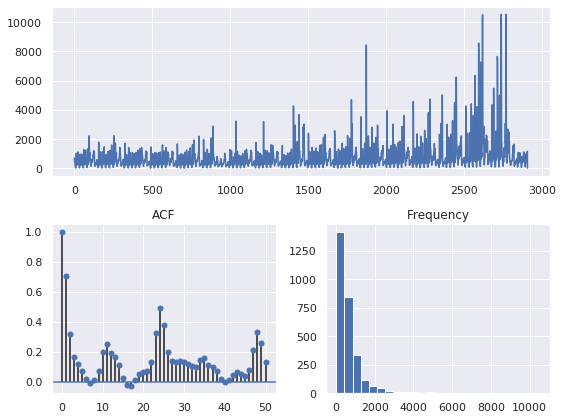

In [9]:
pm.utils.tsdisplay(ts)

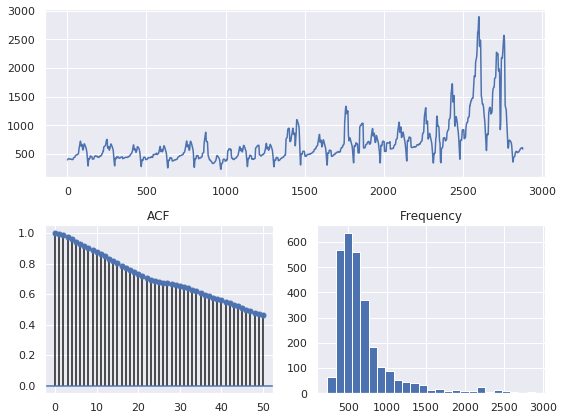

In [10]:
trend = decomp.trend.dropna()
pm.utils.tsdisplay(trend)

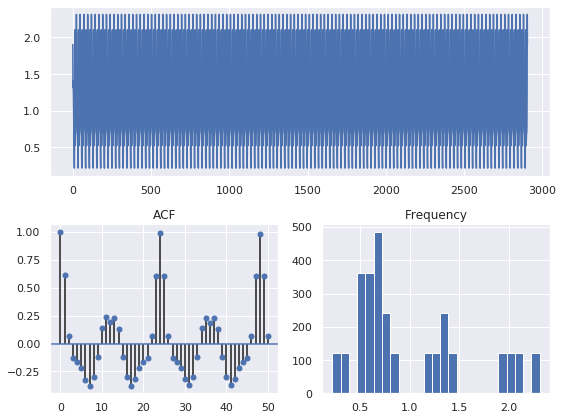

In [11]:
pm.utils.tsdisplay(decomp.seasonal)

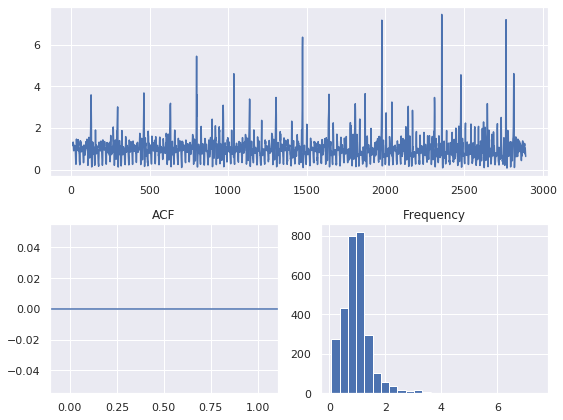

In [12]:
pm.utils.tsdisplay(decomp.resid)

## Decompose the 7-day cycle

After a second decomposition, the trend is clearly, much removed of seasonality and we can run ARIMA again, while we have captured the seasonality in two new timeseries.

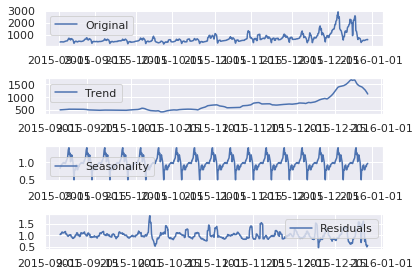

In [13]:
decomp2 = seasonal.seasonal_decompose(
    trend, model='multiplicative', freq=7*24
)
plot_decomposition(plt, decomp.trend, decomp2)
plt.show()

### Lets have a closer look again 
It is clear that the original (first graph) series has decomposed to a simple timeseries (second graph) with much less evidence of seasonality. Also, the residual (fourth graph), when looked at more closely below seems to be cleaner of patterns. Let's keeps this iteration as the one to move forward

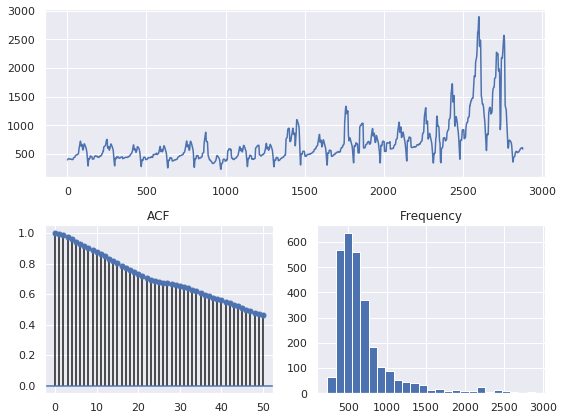

In [14]:
pm.utils.tsdisplay(trend)

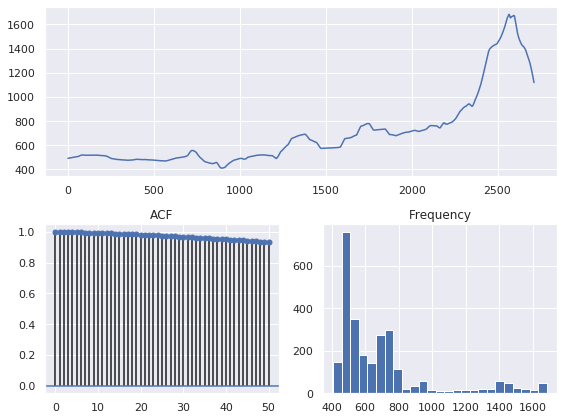

In [15]:
trend2 = decomp2.trend.dropna()
pm.utils.tsdisplay(trend2)

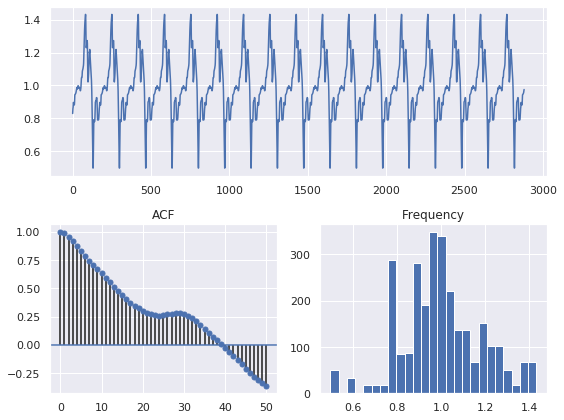

In [16]:
pm.utils.tsdisplay(decomp2.seasonal)

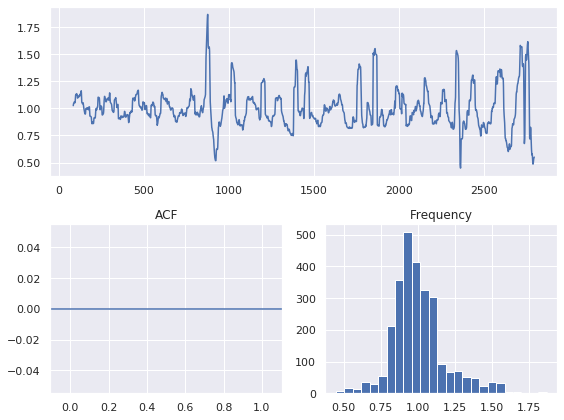

In [17]:
pm.utils.tsdisplay(decomp2.resid)

# Perform ARIMA modeling for the cleaned up trend

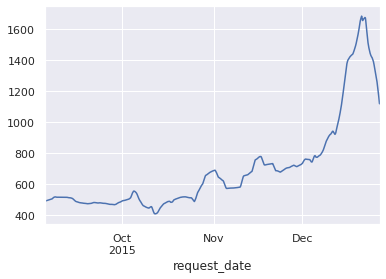

In [18]:
trend2 = decomp2.trend
trend2.dropna(inplace=True)
season = pd.DataFrame(decomp.seasonal)
season2 = pd.DataFrame(decomp2.seasonal)
trend2.plot()


### Run Stationarity tests

The tests suggest non-stationarity and differentiation is in order to achieve stationarity.

In [20]:
n_adf = pm.arima.utils.ndiffs(trend2, test='adf')
n_kpss = pm.arima.utils.ndiffs(trend2, test='kpss')
n_pp = pm.arima.utils.ndiffs(trend2, test='pp')

(n_adf, n_kpss, n_pp)

(1, 2, 1)

In [21]:
from pmdarima.model_selection import train_test_split

season1 = decomp.seasonal.dropna()
y_train_season, y_test_season = train_test_split(trend2, train_size=.9)

## SARIMA with low seasonality

In [23]:
model_fpath = '../models/auto-sarima-detrended-hourly-trip-counts-on-clean-data'
try:
    unseason_model = joblib.load(model_fpath)
except:
    unseason_model = pm.auto_arima(
        y_train_season, 
        start_p=1, start_q=1, start_d=1,
        test='adf',
        max_p=3, max_q=3, max_d=2,
        m=12,
        seasonal=True,
        start_P=0, 
        D=1, 
        trace=True,
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True
    )
    joblib.dump(unseason_model, model_fpath)

In [24]:
unseason_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2441
Model:             SARIMAX(3, 0, 2)x(0, 1, 1, 12)   Log Likelihood                4262.176
Date:                            Thu, 16 Jan 2020   AIC                          -8508.351
Time:                                    13:13:47   BIC                          -8461.990
Sample:                                         0   HQIC                         -8491.495
                                           - 2441                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.720      0.085   -3.56e-05       0.001
ar.L1          2.9438      0.006    454.101      0.000       2.931       2.957
ar.L2         -2.9198      0.013   -226.927      0.000      -2.945      -2.895
ar.L3          0.9759      0.007    147.191      0.000       0.963       0.989
ma.L1          1.9275      0.003    603.118      0.000       1.921       1.934
ma.L2          0.9374      0.003    293.830      0.000       0.931       0.944
ma.S.L12      -0.9826      0.008   -129.994      0.000      -0.997      -0.968
sigma2         0.0017   1.79e-05     94.989      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                     1019.62   Jarque-Bera (JB):            105246.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.80   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Check validity of the model

As we can see, things are still far from perfect. The residuals are not normally destributed, the correlogram falls short of the normal distribution, QQ plots suggests the distribution is skewed and the autocorrelation is out of bounds, implying that some patterns in the residual error are not explained in the model.

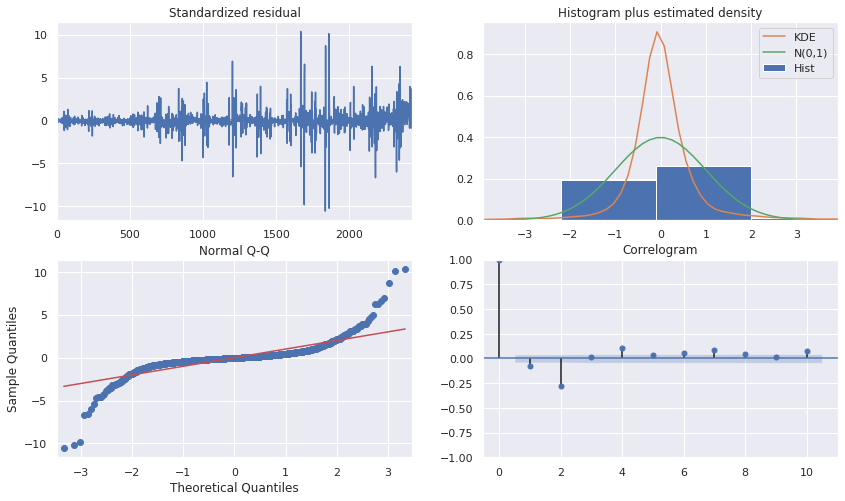

In [25]:

unseason_model.plot_diagnostics(figsize=(14,8))
plt.show()

### In-sample and out-of-sample forecast

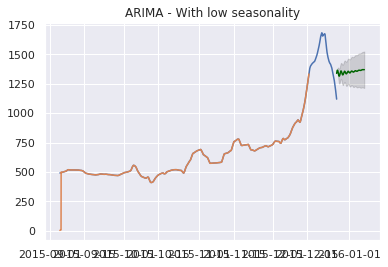

In [26]:
n_periods = len(y_test_season)
fitted, confint = unseason_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(decomp2.trend.index[-1], periods = n_periods, freq='1H')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(decomp2.trend)
plt.plot(pd.Series(
    unseason_model.predict_in_sample(), 
    index=pd.date_range(y_train_season.index[0], periods = len(y_train_season), freq='1H')
))
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA - With low seasonality")
plt.show()

In [30]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test_season, fitted)))


Test RMSE: 183.112


# Conclusion

Deseasoning is a helpfull procedure to isolate the trend of a timeseries and use a more simplified ARIMA model for making predictions. Still more effort is needed for a successful result than time permits.

In the next section we will reach to a well performing model quickly with a more automated procedure, using facebook prophet.